In [5]:
import json
import numpy as np
import polars as pl
import matplotlib.pyplot as plt

file_path = "../../data/letterboxd_not_filtered.jsonl"

try:
    df = pl.read_ndjson(file_path, ignore_errors=True)
    print("Successfully loaded!")
    print(f"Memory size: {df.estimated_size('mb'):.2f} MB\n")
except Exception as e:
    print(f"Error loading file: {e}\n")
    exit(1)

num_films = 0
num_synopses = 0
num_reviews = 0

synopsis_chars = 0
review_chars = 0

with open(file_path, encoding="utf-8") as f:
    for line in f:
        num_films += 1
        data = json.loads(line)

        # Synopsis
        synopsis = data.get("synopsis", "")
        if synopsis:
            num_synopses += 1
            synopsis_chars += len(synopsis)

        # Reviews
        reviews = data.get("review_texts", [])
        num_reviews += len(reviews)
        for r in reviews:
            review_chars += len(r)

total_chars = synopsis_chars + review_chars

print("Films:", num_films)
print("Synopses:", num_synopses)
print("Reviews:", num_reviews)
print("Synopsis characters:", synopsis_chars)
print("Review characters:", review_chars)
print("Total characters:", total_chars)

Successfully loaded!
Memory size: 484.98 MB

Films: 345102
Synopses: 329729
Reviews: 1896774
Synopsis characters: 91229614
Review characters: 391148055
Total characters: 482377669


In [14]:
df_null_values = df.filter(pl.col("synopsis").is_null()).select("title").unique()

print(f"Number of different movies with NULL synopsis: {len(df_null_values)}")
print(df_null_values.head(10))

Number of different movies with NULL synopsis: 2793
shape: (10, 1)
┌─────────────────────────────────┐
│ title                           │
│ ---                             │
│ str                             │
╞═════════════════════════════════╡
│ Stab 3: Holiday Horror          │
│ Moses of the Mill               │
│ La locura de Don Juan           │
│ Crossing Lines                  │
│ Evil Dead: El Musical (Madrid)  │
│ Arctic Monkeys at Corona Capit… │
│ Pachinker Explosion             │
│ El juego de la guitarra         │
│ David Gilmour: Live 1984        │
│ Zakuro Yakata                   │
└─────────────────────────────────┘


In [15]:
short_synopsis = (
    df.filter(pl.col("synopsis").is_not_null() & (pl.col("synopsis").str.split(" ").list.len() <= 10))
    .select(["title", "synopsis", "review_texts"])
    .unique(subset=["title"])
)

print(f"Movies with short synopses: {len(short_synopsis)}")
for row in short_synopsis.head().iter_rows(named=True):
    print(f"\nTitle: {row['title']}")
    print(f"Synopsis: {row['synopsis']}")
    print("-" * 80)

Movies with short synopses: 9642

Title: Henry VI Part 3
Synopsis: The life of King Henry the Sixth, in three parts.
--------------------------------------------------------------------------------

Title: Inspired by Bret Easton Ellis
Synopsis: Commissioned by Random House and Bret Easton Ellis.
--------------------------------------------------------------------------------

Title: Jumpy
Synopsis: Jumpy lives to jump!
--------------------------------------------------------------------------------

Title: je suis coincé à la dérive
Synopsis: Reflections on a murky memory.
--------------------------------------------------------------------------------

Title: Who's Asking About That?
Synopsis: Masked man wonders, "who's asking about that?"
--------------------------------------------------------------------------------



synopsis:
shape: (1, 6)
┌─────┬─────┬───────────┬───────────┬──────────┬────────┐
│ min ┆ max ┆ mean      ┆ std_dev   ┆ total    ┆ median │
│ --- ┆ --- ┆ ---       ┆ ---       ┆ ---      ┆ ---    │
│ u32 ┆ u32 ┆ f64       ┆ f64       ┆ u32      ┆ f64    │
╞═════╪═════╪═══════════╪═══════════╪══════════╪════════╡
│ 1   ┆ 203 ┆ 46.951733 ┆ 32.666607 ┆ 15481348 ┆ 38.0   │
└─────┴─────┴───────────┴───────────┴──────────┴────────┘


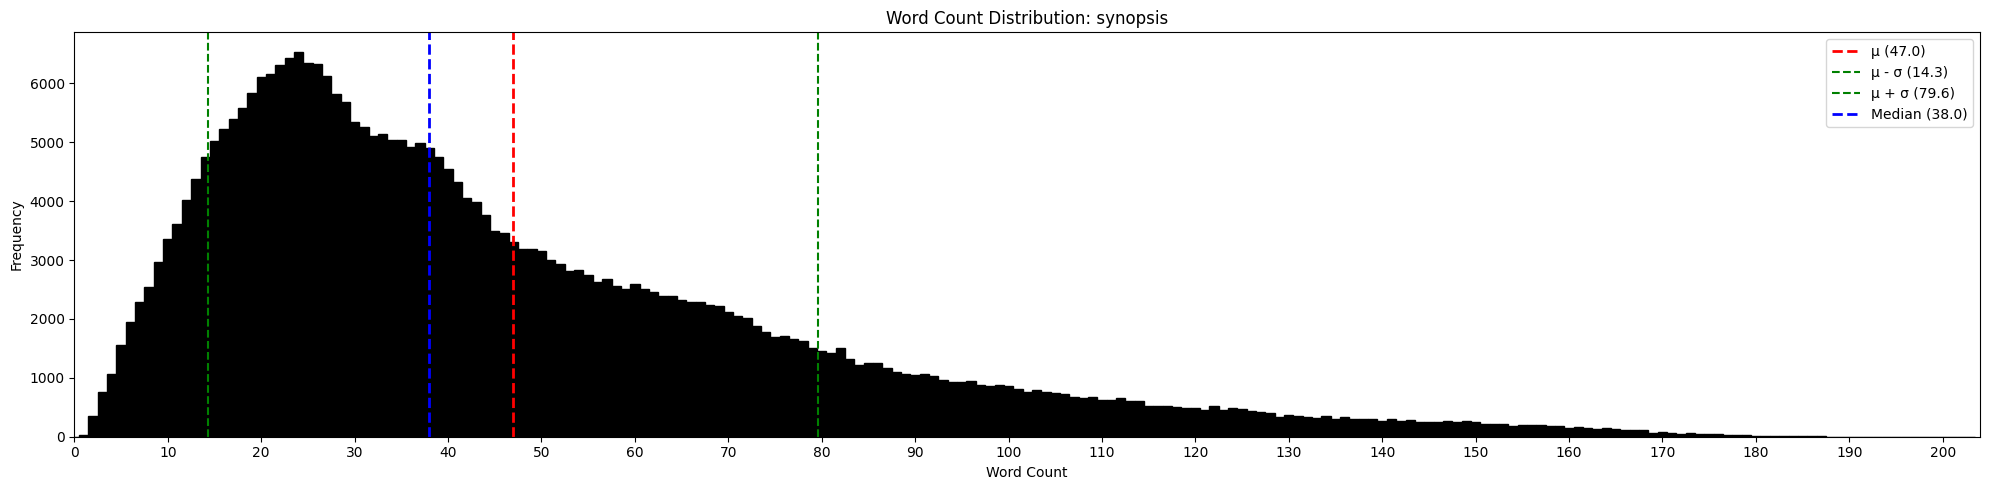


review_texts:
shape: (1, 6)
┌─────┬──────┬────────────┬────────────┬──────────┬────────┐
│ min ┆ max  ┆ mean       ┆ std_dev    ┆ total    ┆ median │
│ --- ┆ ---  ┆ ---        ┆ ---        ┆ ---      ┆ ---    │
│ i64 ┆ i64  ┆ f64        ┆ f64        ┆ i64      ┆ f64    │
╞═════╪══════╪════════════╪════════════╪══════════╪════════╡
│ 1   ┆ 1344 ┆ 194.142355 ┆ 172.833715 ┆ 66998915 ┆ 145.0  │
└─────┴──────┴────────────┴────────────┴──────────┴────────┘


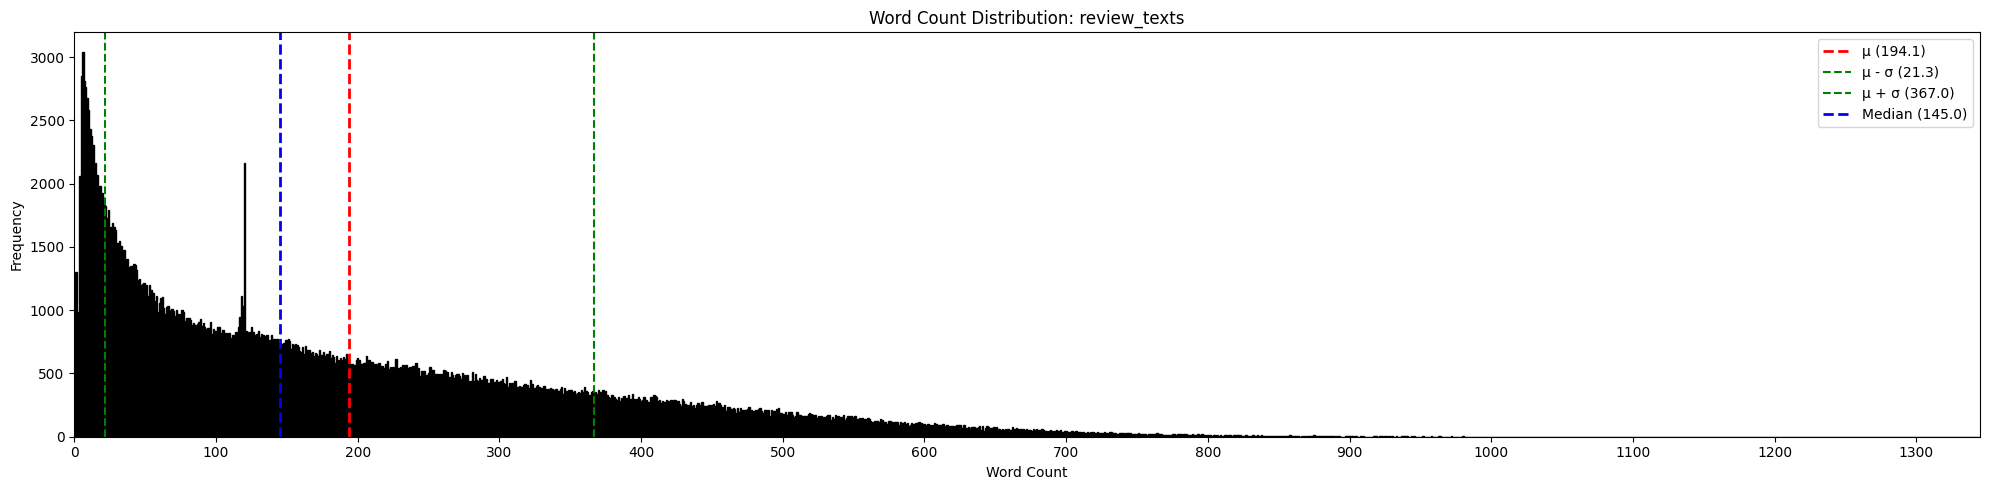

In [7]:
interesting_cols = ["synopsis", "review_texts"]
for col in interesting_cols:
    if col == "review_texts":
        words = df.filter(pl.col(col).is_not_null()).select(
            pl.col(col)
            .list.eval(pl.element().str.split(" "))
            .map_elements(lambda x: sum(len(s) for s in x), return_dtype=pl.Int64)
            .alias("word_count")
        )
        ticks = 100
    else:
        words = df.filter(pl.col(col).is_not_null()).select(pl.col(col).str.split(" ").list.len().alias("word_count"))
        ticks = 10

    stats = words.select(
        pl.col("word_count").min().alias("min"),
        pl.col("word_count").max().alias("max"),
        pl.col("word_count").mean().alias("mean"),
        pl.col("word_count").std().alias("std_dev"),
        pl.col("word_count").sum().alias("total"),
        pl.col("word_count").quantile(0.5).alias("median"),
    )

    print(f"\n{col}:")
    print(stats)

    word_counts = np.array(words["word_count"].to_list())
    mean_val = stats["mean"][0]
    std_val = stats["std_dev"][0]
    median_val = stats["median"][0]

    bins = np.arange(-0.5, word_counts.max() + 1.5, 1)

    plt.figure(figsize=(20, 5))
    plt.hist(word_counts, bins=bins, color="black", edgecolor="black")
    plt.axvline(mean_val, color="red", linestyle="--", linewidth=2, label=f"µ ({mean_val:.1f})")
    plt.axvline(
        mean_val - std_val, color="green", linestyle="--", linewidth=1.5, label=f"µ - σ ({mean_val - std_val:.1f})"
    )
    plt.axvline(
        mean_val + std_val, color="green", linestyle="--", linewidth=1.5, label=f"µ + σ ({mean_val + std_val:.1f})"
    )
    plt.axvline(median_val, color="blue", linestyle="--", linewidth=2, label=f"Median ({median_val:.1f})")
    plt.xticks(np.arange(0, word_counts.max() + 1, ticks))
    plt.xlim(0, word_counts.max() + 1)
    plt.title("Word Count Distribution: " + col)
    plt.xlabel("Word Count")
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.legend()
    plt.show()

In [30]:
import collections
from lingua import Language, LanguageDetectorBuilder
from src.data.data_pre_filter import count_emojis, misspelled_ratio

detector = (
    LanguageDetectorBuilder.from_languages(
        Language.ENGLISH,
        Language.SPANISH,
        Language.FRENCH,
        Language.GERMAN,
        Language.PORTUGUESE,
        Language.ITALIAN,
        Language.DUTCH,
        Language.SWEDISH,
        Language.POLISH,
        Language.RUSSIAN,
        Language.JAPANESE,
        Language.KOREAN,
        Language.CHINESE,
    )
    .with_preloaded_language_models()
    .build()
)

all_reviews = df.select(pl.col("review_texts")).explode("review_texts").drop_nulls().to_series().to_list()

emoji_counts = [count_emojis(r) for r in all_reviews]
# non_latin_counts = [count_non_latin_script_chars(r) for r in all_reviews]
# weird_counts = [count_weird_chars(r) for r in all_reviews]
misspelled_ratios = [misspelled_ratio(r) for r in all_reviews]

detected_lang = []
for r in all_reviews:
    try:
        lang = detector.detect_language_of(r)
        if lang is None:
            detected_lang.append("UNKNOWN")
        else:
            detected_lang.append(lang.name)
    except Exception as e:
        print(e)
        detected_lang.append("UNKNOWN")

lang_counts = collections.Counter(detected_lang)

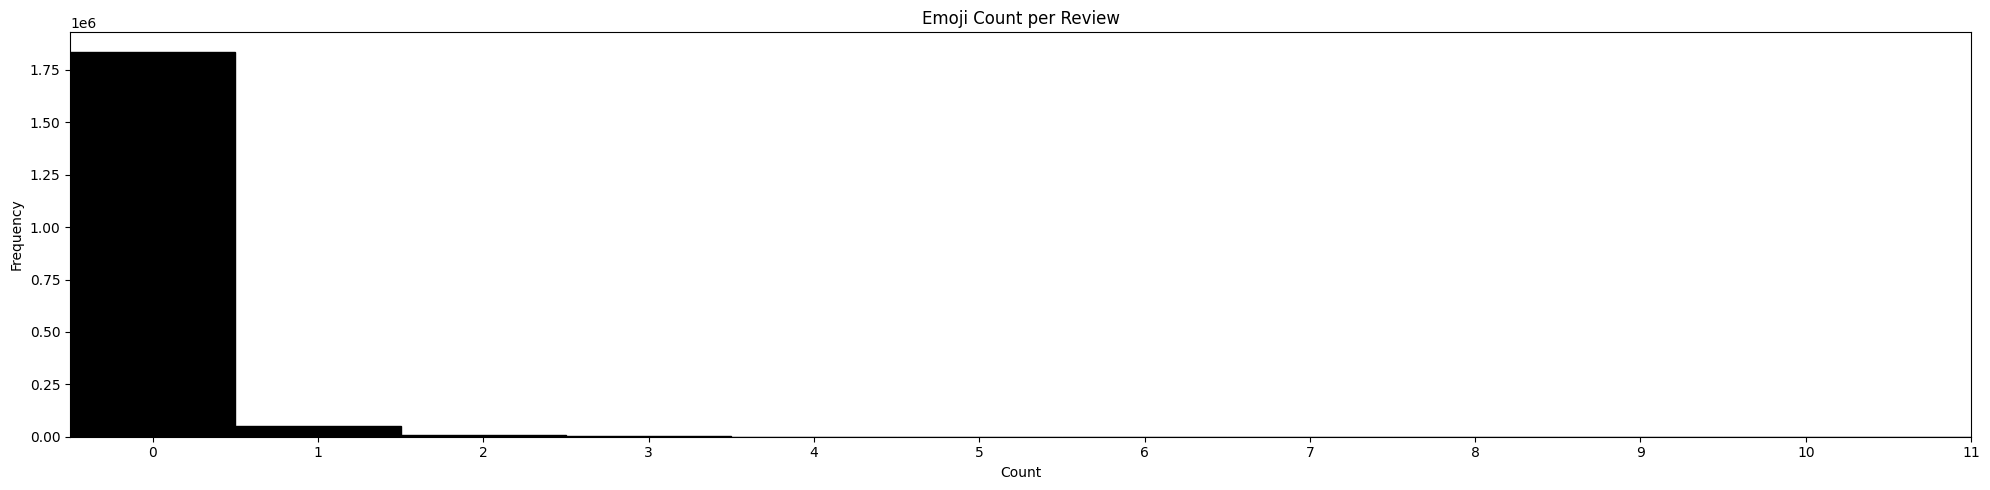

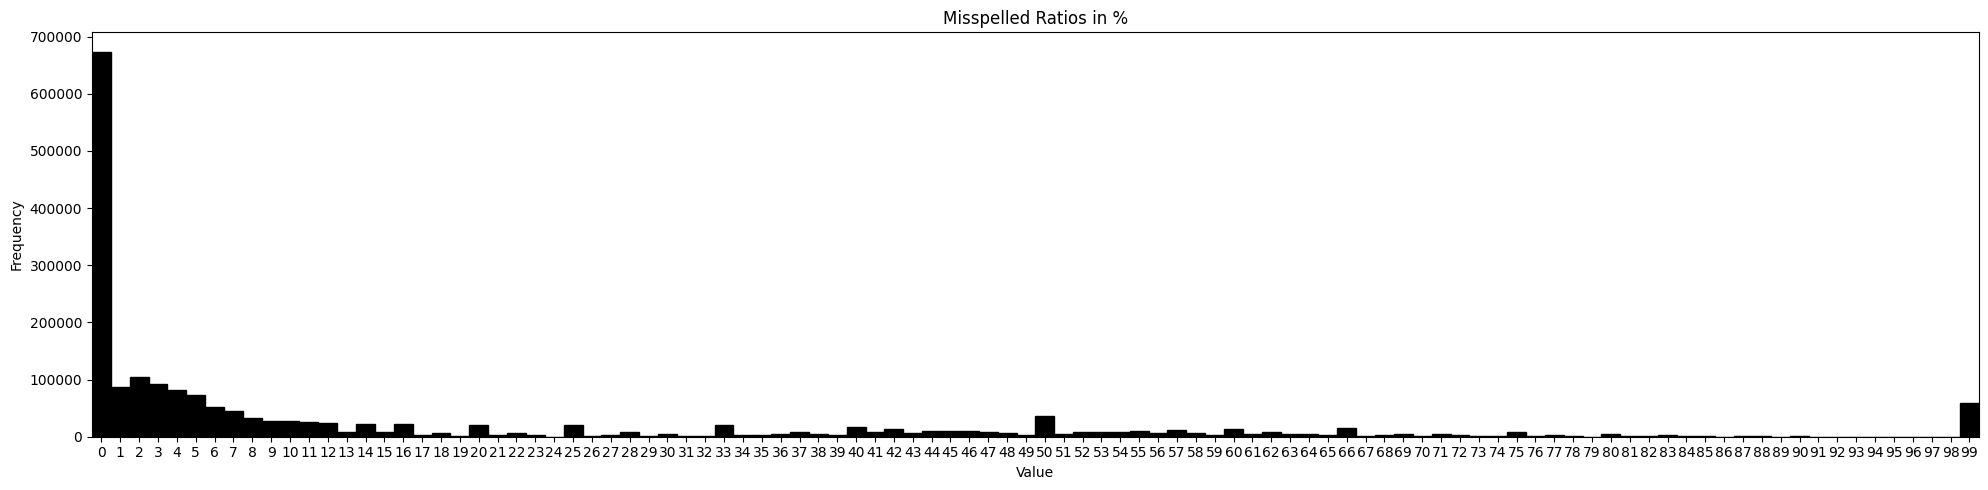

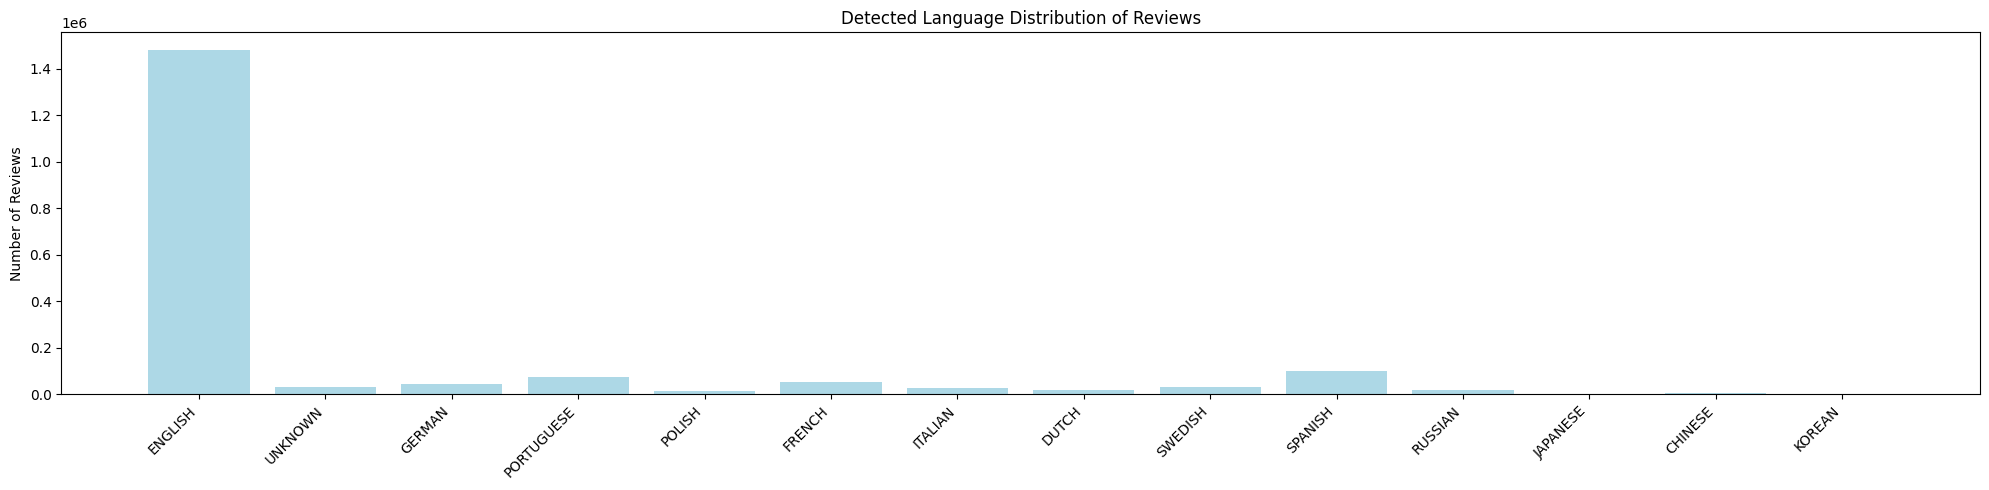

In [37]:
def plot_integer_hist(values, title, tick_step=1, xlim_max=None):
    values = np.array(values)
    min_v = values.min()
    max_v = values.max()
    bins = np.arange(min_v - 0.5, max_v + 1.5, 1)

    plt.figure(figsize=(20, 5))
    plt.hist(values, bins=bins, color="black", edgecolor="black")

    plt.xticks(np.arange(0, max_v + 1, tick_step))
    if xlim_max:
        plt.xlim(-0.5, xlim_max + 1)
    else:
        plt.xlim(-0.5, max_v + 1)
    plt.title(title)
    plt.xlabel("Count")
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()


plot_integer_hist(emoji_counts, "Emoji Count per Review", tick_step=1, xlim_max=10)
# plot_integer_hist(non_latin_counts, "Non-Latin Characters per Review", tick_step=100)
# plot_integer_hist(weird_counts, "Weird Characters (So/Mn/Cf/Co) per Review", tick_step=10)

misspelled_ratios = np.asarray(misspelled_ratios, dtype=float)
bins = 100

plt.figure(figsize=(20, 5))
plt.hist(misspelled_ratios, bins=bins, color="black", edgecolor="black")

tick_step = 0.01
ticks = np.arange(-tick_step / 2, tick_step / 2 + 1, tick_step)
tick_labels = [f"{int(t * 100)}" for t in ticks]
plt.xticks(ticks, tick_labels)

plt.xlim(0, 1)
plt.title("Misspelled Ratios in %")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

plt.figure(figsize=(20, 5))
plt.bar(lang_counts.keys(), lang_counts.values(), color="lightblue")
plt.title("Detected Language Distribution of Reviews")
plt.ylabel("Number of Reviews")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

In [21]:
short_review = df.filter(
    pl.col("review_texts").is_not_null()
    & (pl.col("review_texts").list.eval(pl.element().str.split(" ").list.len()).list.sum() <= 20)
).select(["title", "synopsis", "review_texts"])

print(f"Movies with short review: {len(short_review)}")
for row in short_review.head().iter_rows(named=True):
    print(f"\nTitle: {row['title']}")
    print(f"Review: {row['review_texts']}")
    print("-" * 80)

Movies with short review: 35230

Title: The Lord of the Rings: The Return of the King
Review: ['Sam is fr the real hero of this movie', '[fleabag voice] this is a love story']
--------------------------------------------------------------------------------

Title: Johanne Sacreblu
Review: ["Didn't understand a word of this but hell yea brother Emilia Perez found dead in a ditch"]
--------------------------------------------------------------------------------

Title: Madonna: The Celebration Tour in Rio
Review: ['I FEEL IT IN MY PUSSY']
--------------------------------------------------------------------------------

Title: Interstellar
Review: ["I have a headache, but it's the best headache I've ever had.", 'i needed a REALLY good cry']
--------------------------------------------------------------------------------

Title: ATEEZ WORLD TOUR [TOWARDS THE LIGHT : WILL TO POWER] IN CINEMAS
Review: ['I cried and slowed it down and made it bouncy', 'a tear went down my leg']
--------------